In [1]:
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [8]:
SRC_OBJ_FILE = "../../MP1-assignment-PyCharm/VisualGenome-data-SMALL/objects.json"
SRC_REL_FILE = "../../MP1-assignment-PyCharm/VisualGenome-data-SMALL/relationships.json"
SRC_OBJ_ALIAS_FILE = "../../MP1-assignment-PyCharm/VisualGenome-data/object_alias.txt"
SRC_REL_ALIAS_FILE = "../../MP1-assignment-PyCharm/VisualGenome-data/relationship_alias.txt"
DEBUG_ = False

In [3]:
def construct_object_alias_dict_map():
    alias_data = open(SRC_OBJ_ALIAS_FILE, 'r')
    output_map = {}
    for alias_line in alias_data:
        tmp_list = alias_line.split(",")
        tmp_src = tmp_list[0]
        tmp_targets = tmp_list[1:]
        for tmp_target in tmp_targets:
            output_map[tmp_target] = tmp_src
    return output_map

In [4]:
def construct_relationships_alias_dict_map():
    alias_data = open(SRC_REL_ALIAS_FILE, 'r')
    output_map = {}
    for alias_line in alias_data:
        tmp_list = alias_line.split(",")
        tmp_src = tmp_list[0]
        tmp_targets = tmp_list[1:]
        for tmp_target in tmp_targets:
            output_map[tmp_target] = tmp_src
    return output_map

In [9]:
G = nx.Graph()

object_alias_map = construct_object_alias_dict_map()
rel_alias_map = construct_relationships_alias_dict_map()

data = json.load(open(SRC_REL_FILE, 'r'))  # 10,000
n_data = len(data)
print("No. images : ", n_data)
for image_idx, image in enumerate(data):
    tmp_img_rel = image['relationships']
    for rel_idx, rel in enumerate(tmp_img_rel):
        # primary types
        tmp_rel_id = rel['relationship_id']
        tmp_synsets_detailed_rel = rel['synsets']
        tmp_predicate = rel['predicate']
        tmp_object = rel['object']
        tmp_subject = rel['subject']

        # object type
        tmp_object_id = tmp_object['object_id']
        tmp_object_synsets_detailed_obj = tmp_object['synsets']
        # tmp_object_merged_object_ids = tmp_object.get('merged_object_ids', "")  # maybe linked mention ???
        # tmp_object_names = tmp_object['names']  # difference between 'name' and 'names'
        if tmp_object.get('names', "") != "":
            tmp_object_names = tmp_object['names']
        else:
            tmp_object_names = tmp_object['name']
        if (type(tmp_object_names) == list) and (len(tmp_object_names) > 1):
            print("object found as list with len : ", len(tmp_object_names))
        elif type(tmp_object_names) == list:
            tmp_object_name = tmp_object_names[0]

        # subject type
        tmp_subject_id = tmp_subject['object_id']
        tmp_subject_synsets_detailed_obj = tmp_subject['synsets']  # why sometimes synsets are empty list
        if tmp_subject.get('name', "") != "":
            tmp_subject_name = tmp_subject['name']
        else:
            tmp_subject_name = tmp_subject['names']
        if (type(tmp_subject_name) == list) and (len(tmp_subject_name) > 1):
            print("subject found as list with len : ", len(tmp_subject_name))
        elif type(tmp_subject_name) == list:
            tmp_subject_name = tmp_subject_name[0]

        # Adding nodes to graph
        if tmp_subject_name in object_alias_map.keys():
            # print("Found synonym for object name")
            tmp_subject_name = object_alias_map[tmp_subject_name]
        if tmp_object_name in object_alias_map.keys():
            # print("Found synonym for object name")
            tmp_object_name = object_alias_map[tmp_object_name]
        G.add_node(tmp_subject_name, id=tmp_subject_id, synsets=tmp_subject_synsets_detailed_obj)
        G.add_node(tmp_object_name, id=tmp_object_id, synsets=tmp_object_synsets_detailed_obj)
        # Adding edges to graph : this should actually be a DI-GRAPH
        if tmp_predicate in rel_alias_map.keys():
            tmp_predicate = rel_alias_map[tmp_predicate]
        G.add_edge(tmp_subject_name, tmp_object_name, id=tmp_rel_id, synsets=tmp_synsets_detailed_rel,
                       predicate=tmp_predicate)
        
    if image_idx % 1000 == 0:
        print("finished loading image : {} / {}".format(image_idx + 1, n_data))
        
    if image_idx == 100:
        break    

No. images :  10000
finished loading image : 1 / 10000


# Analysis

In [10]:
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.

In [11]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1350
Number of edges: 4149
Average degree:   6.1467


In [12]:
print(nx.is_connected(G))

False


In [13]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)
print(type(components))

<class 'generator'>


In [14]:
# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.

subgraph_G_largestComp = G.subgraph(largest_component)
diameter = nx.diameter(subgraph_G_largestComp)
print("Network diameter of largest component:", diameter)

Network diameter of largest component: 7


# Num Connected Components

In [15]:
nx.number_connected_components(G)

7

# Analyze on the Sub-grah pf connected component

In [18]:
print(nx.info(subgraph_G_largestComp))

Name: 
Type: Graph
Number of nodes: 1339
Number of edges: 4140
Average degree:   6.1837


In [19]:
print("Number of disconnected nodes from larger component : ", 1350 - 1339)
print("Number of disconnected edges from larger component : ", 4149 - 4140)
print("Average degree differences from larger component : ",  6.1467 - 6.1837)

Number of disconnected nodes from larger component :  11
Number of disconnected edges from larger component :  9
Average degree differences from larger component :  -0.03699999999999992


# Analyze the Connected componenets excluding the larger component

In [26]:
ordered_components =  sorted(nx.connected_components(G), key = len, reverse=True)

In [29]:
len(ordered_components)

7

In [40]:
for i, disconnected_component in enumerate(ordered_components[1:]):
    print("order: index-%s"%(i+2), '\t\t', disconnected_component)

order: index-2 		 {'white/plastic cup', 'beige/wired telephone', 'grey desktop'}
order: index-3 		 {'white napkin', 'top drawer', 'metal handle'}
order: index-4 		 {'sacks', 'pile'}
order: index-5 		 {'arrow on sidewalk.'}
order: index-6 		 {'man has bag.'}
order: index-7 		 {'drinks'}


In [38]:
# nodes in largest component
len(ordered_components[0])
# this is correct as we already got!!!

1339

# Analyze the degrees , in & out degrees of disconnected components

In [41]:
disconnected_node_7 = G.subgraph(ordered_components[-1])
disconnected_node_6 = G.subgraph(ordered_components[-2])
disconnected_node_5 = G.subgraph(ordered_components[-3])
disconnected_node_4 = G.subgraph(ordered_components[-4])
disconnected_node_3 = G.subgraph(ordered_components[-5])
disconnected_node_2 = G.subgraph(ordered_components[-6])

In [42]:
print(nx.info(disconnected_node_7))

Name: 
Type: Graph
Number of nodes: 1
Number of edges: 1
Average degree:   2.0000


In [43]:
print(nx.info(disconnected_node_6))

Name: 
Type: Graph
Number of nodes: 1
Number of edges: 1
Average degree:   2.0000


In [44]:
print(nx.info(disconnected_node_5))

Name: 
Type: Graph
Number of nodes: 1
Number of edges: 1
Average degree:   2.0000


In [45]:
print(nx.info(disconnected_node_4))

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 2
Average degree:   2.0000


In [46]:
print(nx.info(disconnected_node_3))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 2
Average degree:   1.3333


In [47]:
print(nx.info(disconnected_node_2))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 2
Average degree:   1.3333


# Get the edge names of disconnected components

['drinks']
[('drinks', 'drinks')]
{('drinks', 'drinks'): 'IN A'}
{('drinks', 'drinks'): []}


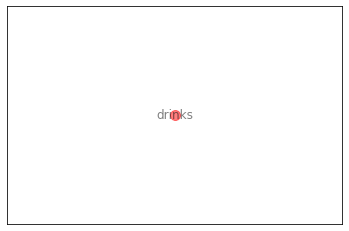

In [68]:
# only edges incident to a single node (use G.adj[0]?)
print(disconnected_node_7.nodes())
print(disconnected_node_7.edges())
print(nx.get_edge_attributes(disconnected_node_7, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_7, 'synsets'))

nx.draw_networkx(disconnected_node_7, pos=nx.spring_layout(G), node_size=100, node_color='r', node_shape='o', alpha=0.5,
                             linewidths=1.0, width=1.0,
                             )

In [63]:
print(disconnected_node_6.nodes())
print(disconnected_node_6.edges())
print(nx.get_edge_attributes(disconnected_node_6, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_6, 'synsets'))

['man has bag.']
[('man has bag.', 'man has bag.')]
{('man has bag.', 'man has bag.'): 'bag plastic'}
{('man has bag.', 'man has bag.'): ['be.v.01']}


['arrow on sidewalk.']
[('arrow on sidewalk.', 'arrow on sidewalk.')]
{('arrow on sidewalk.', 'arrow on sidewalk.'): 'see arrow figure'}
{('arrow on sidewalk.', 'arrow on sidewalk.'): ['see.v.01']}


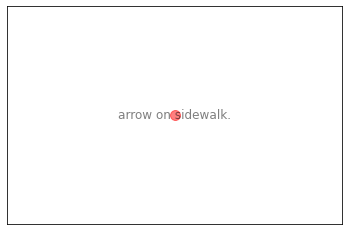

In [69]:
print(disconnected_node_5.nodes())
print(disconnected_node_5.edges())
print(nx.get_edge_attributes(disconnected_node_5, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_5, 'synsets'))

nx.draw_networkx(disconnected_node_5, pos=nx.spring_layout(G), node_size=100, node_color='r', node_shape='o', alpha=0.5,
                             linewidths=1.0, width=1.0,
                             )

['sacks', 'pile']
[('sacks', 'pile'), ('sacks', 'sacks')]
{('sacks', 'pile'): 'ON PILE OF', ('sacks', 'sacks'): 'laying on'}
{('sacks', 'pile'): [], ('sacks', 'sacks'): []}


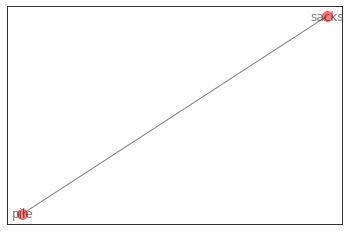

In [70]:
print(disconnected_node_4.nodes())
print(disconnected_node_4.edges())
print(nx.get_edge_attributes(disconnected_node_4, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_4, 'synsets'))

nx.draw_networkx(disconnected_node_4, pos=nx.spring_layout(G), node_size=100, node_color='r', node_shape='o', alpha=0.5,
                             linewidths=1.0, width=1.0,
                             )

['white napkin', 'top drawer', 'metal handle']
[('white napkin', 'top drawer'), ('top drawer', 'metal handle')]
{('white napkin', 'top drawer'): 'ON', ('top drawer', 'metal handle'): 'ON'}
{('white napkin', 'top drawer'): [], ('top drawer', 'metal handle'): []}


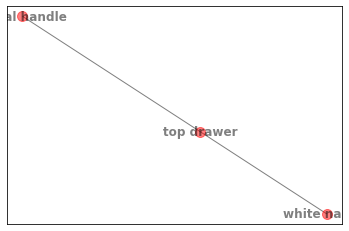

In [75]:
print(disconnected_node_3.nodes())
print(disconnected_node_3.edges())
print(nx.get_edge_attributes(disconnected_node_3, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_3, 'synsets'))

nx.draw_networkx(disconnected_node_3, 
                 pos=nx.spring_layout(G), 
                 node_size=100, node_color='r', node_shape='o', alpha=0.5, linewidths=1.0, width=1.0,
                 with_labels=True, font_weight='bold'
                )

['white/plastic cup', 'beige/wired telephone', 'grey desktop']
[('white/plastic cup', 'grey desktop'), ('beige/wired telephone', 'grey desktop')]
{('white/plastic cup', 'grey desktop'): 'ON', ('beige/wired telephone', 'grey desktop'): 'ON'}
{('white/plastic cup', 'grey desktop'): [], ('beige/wired telephone', 'grey desktop'): []}


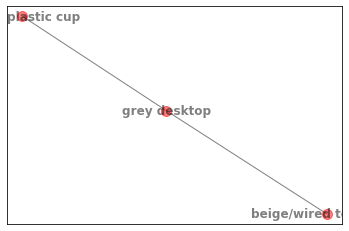

In [76]:
print(disconnected_node_2.nodes())
print(disconnected_node_2.edges())
print(nx.get_edge_attributes(disconnected_node_2, 'predicate'))
print(nx.get_edge_attributes(disconnected_node_2, 'synsets'))

nx.draw_networkx(disconnected_node_2, 
                 pos=nx.spring_layout(G), 
                 node_size=100, node_color='r', node_shape='o', alpha=0.5, linewidths=1.0, width=1.0,
                 with_labels=True, font_weight='bold'
                )
plt.savefig("disconnected_node_2.svg")

# Main function to draw a small sub-graph

In [107]:
def draw_graph_with_edge(graph, save_name):
    pos = nx.spring_layout(graph)

    nx.draw(graph, pos, with_labels=True, font_weight='bold')
#     node_labels = nx.get_node_attributes(graph, 'id')
#     print(node_labels)
#     nx.draw_networkx_labels(graph, 
#                             pos, 
#                             labels = node_labels)
    edge_labels = nx.get_edge_attributes(graph,'predicate')
    nx.draw_networkx_edge_labels(graph, 
                                 pos, 
                                 edge_labels = edge_labels)
    plt.savefig(save_name)
    plt.show()

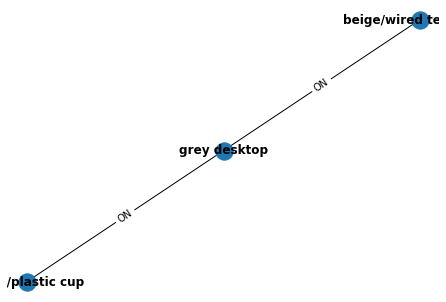

In [108]:
draw_graph_with_edge(disconnected_node_2, 'disconnected_node_2.svg')

In [109]:
list(disconnected_node_2.nodes(data=True))

[('white/plastic cup', {'id': 4294884, 'synsets': []}),
 ('beige/wired telephone', {'id': 4294877, 'synsets': []}),
 ('grey desktop', {'id': 4294906, 'synsets': []})]

# Now focus on larger connected component

In [111]:
H = G.subgraph(ordered_components[0])
print(nx.info(H))

Name: 
Type: Graph
Number of nodes: 1339
Number of edges: 4140
Average degree:   6.1837


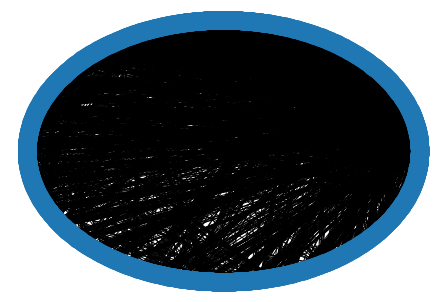

In [118]:
nx.draw_circular(H)

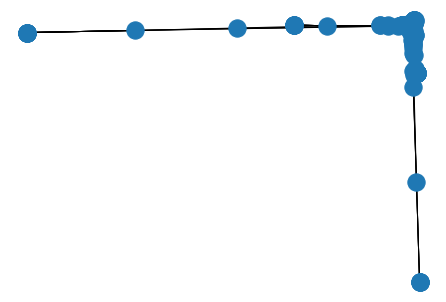

In [120]:
nx.draw_spectral(H)

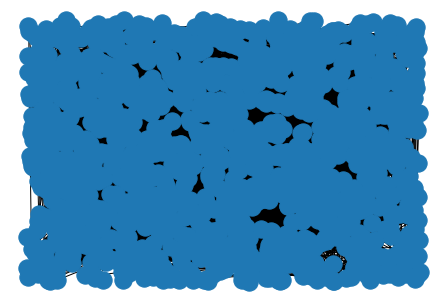

In [122]:
nx.draw_random(H)

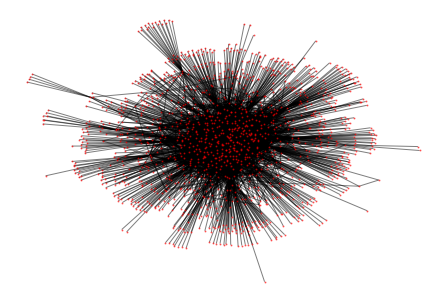

In [127]:
nx.draw(H,
        node_size=1, node_color='r', node_shape='o', alpha=0.5, linewidths=1.0, width=1.0,
        pos=nx.spring_layout(H))
plt.savefig("full-plot.svg")

# degree distribution

In [128]:
degree_dict = dict(H.degree(H.nodes()))
nx.set_node_attributes(H, degree_dict, 'degree')

In [129]:
H_sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), rJuxtaposeeverse=True)

In [138]:
degree_values = sorted(set(degree_dict.values()))
H_degree_hist = [list(degree_dict.values()).count(x) for x in degree_values]

In [143]:
plt.figure() # you need to first do 'import pylab as plt' 
plt.grid(True)
plt.plot(degree_values, H_degree_hist, 'ro-') # in-degree 
# plt.plot(out_values, out_hist, 'bv-') # out-degree 
plt.legend(['degree']) 
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('network of places in Cambridge') 
plt.xlim([0, 2*10**2]) 
plt.savefig('cam_net_degree_distribution_1.svg') 
plt.close()

In [142]:
plt.figure() # you need to first do 'import pylab as plt' 
plt.grid(True)
plt.loglog(degree_values, H_degree_hist, 'ro-') # in-degree 
# plt.plot(out_values, out_hist, 'bv-') # out-degree 
plt.legend(['degree']) 
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('network of places in Cambridge') 
plt.xlim([0, 2*10**2]) 
plt.savefig('cam_net_degree_distribution_2.svg') 
plt.close()

<ipython-input-142-7bc40c9a482c>:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 2*10**2])


In [151]:
print("Top 20 nodes by degree:")
for d in H_sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('table', 193)
('chair', 136)
('road', 135)
('street', 132)
('building', 121)
('window', 121)
('sign', 115)
('tree', 105)
('woman', 94)
('person', 92)
('painting', 91)
('light', 90)
('wall', 89)
('house', 89)
('box', 85)
('man', 83)
('photo', 83)
('car', 76)
('door', 73)
('railing', 66)


# Clustering Coefficient

In [152]:
print("Clustering coefficient of higher degree node : ", nx.clustering(H, 'man'))

# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(H)

# Average clustering coefficient
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients) 
print("Average Clustering coefficient : ", avg_clust)

# Or use directly the built-in method
print("Average Clustering coefficient : ", nx.average_clustering(H))

Clustering coefficient of higher degree node :  0.037531000275558
Average Clustering coefficient :  0.12376297540797836
Average Clustering coefficient :  0.12376297540797836


# Triadic Closure - transitivity

In [148]:
triadic_closure = nx.transitivity(H)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.12153581012306838


In [149]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.12153440438599535


# Node centrality

In [170]:
# # Betweenness centrality
# bet_cen = nx.betweenness_centrality(H)
# # Closeness centrality
# clo_cen = nx.closeness_centrality(H)
# # Eigenvector centrality
# eig_cen = nx.eigenvector_centrality(H)

In [153]:
betweenness_dict = nx.betweenness_centrality(H) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(H) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(H, betweenness_dict, 'betweenness')
nx.set_node_attributes(H, eigenvector_dict, 'eigenvector')

In [154]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)

Top 20 nodes by betweenness centrality:
('table', 0.14198177998245765)
('chair', 0.08903437112923328)
('window', 0.0813558544511563)
('road', 0.08121413079545453)
('street', 0.07692879530998133)
('building', 0.07073769780096119)
('sign', 0.0524440360316241)
('tree', 0.05049413357981276)
('house', 0.04721834196190823)
('woman', 0.04174129349075063)
('painting', 0.04058704723220163)
('man', 0.03927960206887005)
('door', 0.038692737536942745)
('light', 0.038399550956914684)
('person', 0.038286163916693206)
('wall', 0.03811920074807738)
('an', 0.03621084841097687)
('box', 0.033807631436416706)
('photo', 0.033392848964166895)
('railing', 0.03222833349590104)


In [155]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:20]:
    print(b)

Top 20 nodes by eigenvector centrality:
('tree', 0.1985202149223143)
('window', 0.19804131177340425)
('chair', 0.19329381769913853)
('building', 0.19194263952005408)
('sign', 0.18994536309738272)
('table', 0.18913985757542917)
('woman', 0.16791146401248172)
('man', 0.16682621941978482)
('road', 0.1663986324185523)
('light', 0.16457340774204599)
('person', 0.1582302206659262)
('street', 0.15729511002405638)
('wall', 0.15333303999005074)
('car', 0.1515259811886519)
('painting', 0.13954543318400717)
('box', 0.1358626729478859)
('photo', 0.1255455002215141)
('house', 0.11606499882556058)
('license plate', 0.11131389615736464)
('pole', 0.11083430347430731)


## juxtapose the results

In [157]:
#First get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

#Then find and print their degree
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "\t| Betweenness Centrality:", tb[1], "\t| Degree:", degree)

Name: table 	| Betweenness Centrality: 0.14198177998245765 	| Degree: 193
Name: chair 	| Betweenness Centrality: 0.08903437112923328 	| Degree: 136
Name: window 	| Betweenness Centrality: 0.0813558544511563 	| Degree: 121
Name: road 	| Betweenness Centrality: 0.08121413079545453 	| Degree: 135
Name: street 	| Betweenness Centrality: 0.07692879530998133 	| Degree: 132
Name: building 	| Betweenness Centrality: 0.07073769780096119 	| Degree: 121
Name: sign 	| Betweenness Centrality: 0.0524440360316241 	| Degree: 115
Name: tree 	| Betweenness Centrality: 0.05049413357981276 	| Degree: 105
Name: house 	| Betweenness Centrality: 0.04721834196190823 	| Degree: 89
Name: woman 	| Betweenness Centrality: 0.04174129349075063 	| Degree: 94
Name: painting 	| Betweenness Centrality: 0.04058704723220163 	| Degree: 91
Name: man 	| Betweenness Centrality: 0.03927960206887005 	| Degree: 83
Name: door 	| Betweenness Centrality: 0.038692737536942745 	| Degree: 73
Name: light 	| Betweenness Centrality: 0.0

# Community detection with modularity

In [161]:
communities = community.greedy_modularity_communities(H)

In [163]:
len(communities)

12

In [164]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): 
    # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each node in a community
        modularity_dict[name] = i 
        # Create an entry in the dictionary for the node, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(H, modularity_dict, 'modularity')

In [167]:
# First get a list of just the nodes in that class
class0 = [n for n in H.nodes() if H.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:H.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:\n")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "\t| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:

Name: tree 	| Eigenvector Centrality: 0.1985202149223143
Name: building 	| Eigenvector Centrality: 0.19194263952005408
Name: sign 	| Eigenvector Centrality: 0.18994536309738272
Name: man 	| Eigenvector Centrality: 0.16682621941978482
Name: light 	| Eigenvector Centrality: 0.16457340774204599


In [169]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+ str(i)+':') # Print out the classes and their members
        print(list(c))

Class 0:
['walkway', 'numbers', 'grey rock', 'turner', 'zebra', 'tail light', 'puddles', "car's", 'address plate', 'small ripples', 'crane', 'black hair', 'pipes', 'front', 'mulch', 'hubcap', 'towel rack', 'cord plug', 'forks', 'greenbush', 'oval', 'license plate', 'tan house', 'decals', 'large', 'burger', 'sandwich', 'business name', 'card', 'shops', 'blue jacket', 'cone', 'statue', 'hydrant', 'gravy boat', 'sweatshirt', 'ac', 'underpass', 'sign post', 'pack', 'doughnut', 'platform', 'windmill', 'grass patch', 'parkingspaces', 'taxicab', 'storage bin', 'pillar', 'flower pot', 'porch', 'trinket', 'pipe stack', 'streetlight', 'track', 'cars row', 'center', 'sky', 'cup', 'shoppers', 'planters', 'dog', 'background', 'water', 'line', 'tripod', 'hill', 'trafficcone', 'house', "woman's face", 'crack', 'vehicle', 'leaf', 'shadow', 'flag', 'crosswalk', 'sunligt', 'ramp', 'piece', 'tree trunk', 'storm door', 'mo-ped', 'grid', 'parking spaces', 'purse', 'dirt', 'three stroy building', 'street', 

# Eccentricity

In [172]:
print(nx.eccentricity(H, 'table'))
print(nx.eccentricity(H, 'chair'))

4
4


# Page Rank

In [179]:
pr = nx.pagerank(G, alpha=0.9)
for i, (k, v) in enumerate(pr.items()):
    if i == 10: break
    print(k, '\t', v)

shade 	 0.000879695084108548
sidewalk 	 0.0061174775786336805
man 	 0.008504014765228503
shoes 	 0.0010593761991033054
car 	 0.008016101876434888
sign 	 0.012326753231382919
tree trunk 	 0.00037630857989190126
parking meter 	 0.003033391761094596
bike 	 0.002488721388757205
van 	 0.001969577629333736


In [181]:
pr = nx.pagerank(G, alpha=0.9)
n_items = len(pr)
for i, (k, v) in enumerate(pr.items()):
    if i >= n_items - 10:
        print(k, '\t', v)

black stain 	 0.00021109562783603437
gold cord 	 0.00021109562783603437
glass table 	 0.00018146836342794014
white shade 	 0.00018146836342794014
power wire 	 0.00017944780897710146
alarm clock 	 0.0001866857318432498
bar soap 	 0.0001866857318432498
coffee mugs 	 0.0001866857318432498
coffee pot 	 0.0001866857318432498
black cord 	 0.0001866857318432498


In [184]:
nodes_on_shortest_path = nx.shortest_path(H, 'shade', 'black cord')
SG = H.subgraph(nodes_on_shortest_path)

nx.draw(SG, pos=nx.spring_layout(SG), with_labels=True)

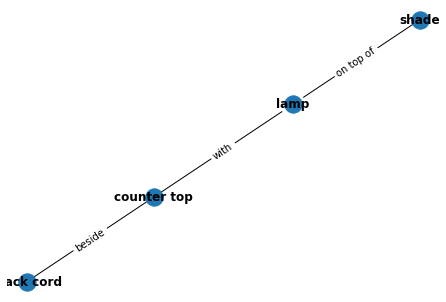

In [186]:
draw_graph_with_edge(SG, 'shade-black cord __subgraph.svg')

# Plot a single image Scene-Graph

In [187]:
minG = nx.Graph()

object_alias_map = construct_object_alias_dict_map()
rel_alias_map = construct_relationships_alias_dict_map()

data = json.load(open(SRC_REL_FILE, 'r'))  # 10,000
n_data = len(data)
print("No. images : ", n_data)
for image_idx, image in enumerate(data):
    tmp_img_rel = image['relationships']
    for rel_idx, rel in enumerate(tmp_img_rel):
        # primary types
        tmp_rel_id = rel['relationship_id']
        tmp_synsets_detailed_rel = rel['synsets']
        tmp_predicate = rel['predicate']
        tmp_object = rel['object']
        tmp_subject = rel['subject']

        # object type
        tmp_object_id = tmp_object['object_id']
        tmp_object_synsets_detailed_obj = tmp_object['synsets']
        # tmp_object_merged_object_ids = tmp_object.get('merged_object_ids', "")  # maybe linked mention ???
        # tmp_object_names = tmp_object['names']  # difference between 'name' and 'names'
        if tmp_object.get('names', "") != "":
            tmp_object_names = tmp_object['names']
        else:
            tmp_object_names = tmp_object['name']
        if (type(tmp_object_names) == list) and (len(tmp_object_names) > 1):
            print("object found as list with len : ", len(tmp_object_names))
        elif type(tmp_object_names) == list:
            tmp_object_name = tmp_object_names[0]

        # subject type
        tmp_subject_id = tmp_subject['object_id']
        tmp_subject_synsets_detailed_obj = tmp_subject['synsets']  # why sometimes synsets are empty list
        if tmp_subject.get('name', "") != "":
            tmp_subject_name = tmp_subject['name']
        else:
            tmp_subject_name = tmp_subject['names']
        if (type(tmp_subject_name) == list) and (len(tmp_subject_name) > 1):
            print("subject found as list with len : ", len(tmp_subject_name))
        elif type(tmp_subject_name) == list:
            tmp_subject_name = tmp_subject_name[0]

        # Adding nodes to graph
        if tmp_subject_name in object_alias_map.keys():
            # print("Found synonym for object name")
            tmp_subject_name = object_alias_map[tmp_subject_name]
        if tmp_object_name in object_alias_map.keys():
            # print("Found synonym for object name")
            tmp_object_name = object_alias_map[tmp_object_name]
        minG.add_node(tmp_subject_name, id=tmp_subject_id, synsets=tmp_subject_synsets_detailed_obj)
        minG.add_node(tmp_object_name, id=tmp_object_id, synsets=tmp_object_synsets_detailed_obj)
        # Adding edges to graph : this should actually be a DI-GRAPH
        if tmp_predicate in rel_alias_map.keys():
            tmp_predicate = rel_alias_map[tmp_predicate]
        minG.add_edge(tmp_subject_name, tmp_object_name, id=tmp_rel_id, synsets=tmp_synsets_detailed_rel,
                       predicate=tmp_predicate)
        
    if image_idx == 0:
        break    

No. images :  10000


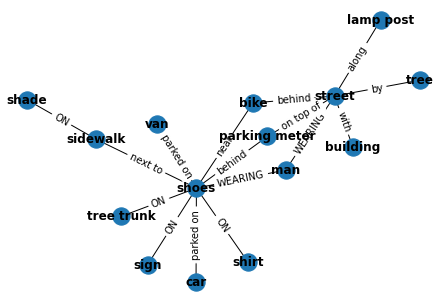

In [189]:
draw_graph_with_edge(minG, 'example-single-image-scene-graph.svg')

# Word Embeddings into Scene-graph

In [190]:
# import numpy as np

# def loadGloveModel(File):
#     print("Loading Glove Model")
#     f = open(File,'r')
#     gloveModel = {}
#     for line in f:
#         splitLines = line.split()
#         word = splitLines[0]
#         wordEmbedding = np.array([float(value) for value in splitLines[1:]])
#         gloveModel[word] = wordEmbedding
#     print(len(gloveModel)," words loaded!")
#     return gloveModel

In [192]:
embeddings_dict = {}
with open("./glove/glove_6B_100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

# Start contextual word and visual proximity

In [194]:
import numpy as np
from scipy.spatial import distance

In [208]:
word_embedding_vec_dict = {}
for i, node in enumerate(H.nodes()):
    word_embedding_vec_dict[node] = embeddings_dict.get(node, np.zeros(100, np.float32))

In [218]:
def neighbour_nodes_of(node, dist_matrix, distance):
    row = dist_matrix[node]
    return np.where((row <= distance) * (row > 0))[0]

nodes = list(word_embedding_vec_dict.keys())
coords = list(word_embedding_vec_dict.values())

threshold = 80.

dist_matrix = distance.cdist(coords, coords)

# this is something you can write to a file instead
for i, node_id in enumerate(nodes):
    neighbours = neighbour_nodes_of(i, dist_matrix, threshold)
    neighbour_ids = [nodes[n] for n in neighbours]
    print([node_id] + neighbour_ids[:8])

    if i == 10: break 

['shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['sidewalk', 'shade', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['man', 'shade', 'sidewalk', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['shoes', 'shade', 'sidewalk', 'man', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['car', 'shade', 'sidewalk', 'man', 'shoes', 'sign', 'tree trunk', 'parking meter', 'bike']
['sign', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'tree trunk', 'parking meter', 'bike']
['tree trunk', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'bike', 'van']
['parking meter', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'bike', 'van']
['bike', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']
['van', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']
['shirt', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']


In [220]:
# draw_graph_with_edge(minG, 'example-single-image-scene-graph.svg')

minG_embeddings = {}
for i, node in enumerate(minG.nodes()):
    minG_embeddings[node] = embeddings_dict.get(node, np.zeros(100, np.float32))
    
def neighbour_nodes_of(node, dist_matrix, distance):
    row = dist_matrix[node]
    return np.where((row <= distance) * (row > 0))[0]

nodes = list(minG_embeddings.keys())
coords = list(minG_embeddings.values())

dist_matrix = distance.cdist(coords, coords)

for i, node_id in enumerate(nodes):
    neighbours = neighbour_nodes_of(i, dist_matrix, threshold)
    neighbour_ids = [nodes[n] for n in neighbours]
    print([node_id] + neighbour_ids[:8])


['shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['sidewalk', 'shade', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['man', 'shade', 'sidewalk', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['shoes', 'shade', 'sidewalk', 'man', 'car', 'sign', 'tree trunk', 'parking meter', 'bike']
['car', 'shade', 'sidewalk', 'man', 'shoes', 'sign', 'tree trunk', 'parking meter', 'bike']
['sign', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'tree trunk', 'parking meter', 'bike']
['tree trunk', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'bike', 'van']
['parking meter', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'bike', 'van']
['bike', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']
['van', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']
['shirt', 'shade', 'sidewalk', 'man', 'shoes', 'car', 'sign', 'tree trunk', 'parking meter']
['lam

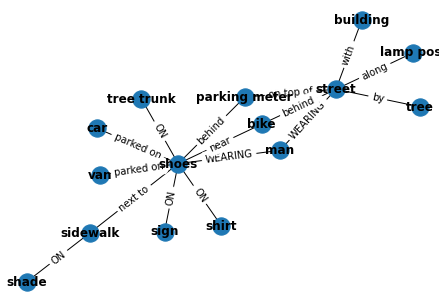

In [221]:
draw_graph_with_edge(minG, 'example-single-image-scene-graph.svg')